# Importing Libraries

In [21]:
import pymongo
import pandas as pd
import json
import requests
import pandas as pd
from pymongo import MongoClient
import csv
import xml.etree.ElementTree as ET

# Connecting and Creating Database in MongoDB 

In [22]:
#takes an air quality API url as an input parameter.
client=pymongo.MongoClient("mongodb://localhost:27017")
#establishing a connection to a local MongoDB server using default port(27017)
db = client['dbairpollution']
collection = db['airpoll_xml']

# Fetching data from URL

In [23]:
import requests
response = requests.get("https://data.cityofnewyork.us/api/views/c3uy-2p5r/rows.xml?accessType=DOWNLOAD")
    #requesting the air quality data and then saving it in the variable 
    #data is returned as xml file and then saved in 'Air_quality.xml' file 
with open('Air_quality.xml', 'wb') as file:
    file.write(response.content)  
air_quality_df = ET.parse("Air_quality.xml").getroot() #parsing the xml file and extracting the data from various path within XML structure
    

# Feteching data from MongoDB to perform ETL


In [24]:
#defining the paths for easy extraction of the data from the hierarchy of the XML file
#in below ".//row/row/unique_id" and respective indicates an XML file path that contains specific entity from the hirearchy
ID_PATH           = ".//row/row/unique_id"
indicator_id_path = ".//row/row/indicator_id" 
name_path         = ".//row/row/name" 
measure_path      = ".//row/row/measure"
measure_info_path = ".//row/row/measure_info"
geo_type_path     = ".//row/row/geo_type_name"
geo_id_path       = ".//row/row/geo_join_id"
geo_place_path    = ".//row/row/geo_place_name"
time_path         = ".//row/row/time_period"
start_date_path   = ".//row/row/start_date"
data_value_path   = ".//row/row/data_value"

#creating a variable with empty list so that in next we can iterate through the element and store it
Unique_ID = []
Indicator_ID = []
name = []
measure = []
measure_info = []
geo_type = []
geo_id = []
geo_place = []
time = []
start_date = []
data_value = []

#looping through all the elements in the data that matches the path specified above: 
    
for elements in air_quality_df.iterfind(ID_PATH):  
    Unique_ID.append(elements.text)
for elements1 in air_quality_df.iterfind(indicator_id_path):  
    Indicator_ID.append(elements1.text)
for elements2 in air_quality_df.iterfind(name_path):
    name.append(elements2.text)
for elements3 in air_quality_df.iterfind(measure_path):
    measure.append(elements3.text)
for elements4 in air_quality_df.iterfind(measure_info_path):
    measure_info.append(elements4.text)
for elements5 in air_quality_df.iterfind(geo_type_path):
    geo_type.append(elements5.text)
for elements6 in air_quality_df.iterfind(geo_id_path):
    geo_id.append(elements6.text)
for elements7 in air_quality_df.iterfind(geo_place_path):
    geo_place.append(elements7.text)
for elements8 in air_quality_df.iterfind(time_path):
    time.append(elements8.text)
for elements9 in air_quality_df.iterfind(start_date_path):
    start_date.append(elements9.text)
for elements10 in air_quality_df.iterfind(data_value_path):
    data_value.append(elements10.text)

#creating the dataframe using pandas library from above variables defined earlier
airquality_data_frame = pd.DataFrame(
{'unique_id': Unique_ID,
    'indicator_id': Indicator_ID,
    'name': name,
    'measure': measure,
    'measure_info': measure_info,
    'geo_type_name': geo_type,
    'geo_join_id': geo_id,
    'geo_place_name': geo_place,
    'time_period': time,
    'start_date': start_date,
    'data_value': data_value
})
    
airquality_data_frame = airquality_data_frame.dropna()
airquality_data_frame = airquality_data_frame.drop_duplicates(subset=['unique_id'])
    
air_df_dict = airquality_data_frame.to_dict("records")
db.air_quality.insert_many(air_df_dict)
airquality_data_frame.to_csv("data_air.csv",index=False)

# Performing ETL

In [25]:
import psycopg2
import pandas as pd
from functools import reduce
import plotly.offline as pyo
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go

In [26]:
# Extract

data_air_csv=pd.read_csv("data_air.csv")

# Transform

data_air_csv['date'] = pd.to_datetime(data_air_csv['start_date']) # convert date to datetime
data_air_csv['year'] = data_air_csv['date'].dt.year # extract year from date

# load
#data_air_csv.to_csv('new_data.csv', index=True) # save transformed data to new CSV file
data_air_csv.reset_index(inplace=True)

# Load
data_air_csv

,index,unique_id,indicator_id,name,measure,measure_info,geo_type_name,geo_join_id,geo_place_name,time_period,start_date,data_value,date,year
0,0,216498,386,Ozone (O3),Mean,ppb,CD,313,Coney Island (CD13),Summer 2013,2013-06-01T00:00:00,34.64,2013-06-01,2013
1,1,216499,386,Ozone (O3),Mean,ppb,CD,313,Coney Island (CD13),Summer 2014,2014-06-01T00:00:00,33.22,2014-06-01,2014
2,2,219969,386,Ozone (O3),Mean,ppb,Borough,1,Bronx,Summer 2013,2013-06-01T00:00:00,31.25,2013-06-01,2013
3,3,219970,386,Ozone (O3),Mean,ppb,Borough,1,Bronx,Summer 2014,2014-06-01T00:00:00,31.15,2014-06-01,2014
4,4,164876,383,Sulfur Dioxide (SO2),Mean,ppb,CD,211,Morris Park and Bronxdale (CD11),Winter 2008-09,2008-12-01T00:00:00,5.89,2008-12-01,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16117,16117,671118,386,Ozone (O3),Mean,ppb,CD,306,Park Slope and Carroll Gardens (CD6),Summer 2020,2020-06-01T00:00:00,28.70,2020-06-01,2020
16118,16118,671119,386,Ozone (O3),Mean,ppb,CD,305,East New York and Starrett City (CD5),Summer 2020,2020-06-01T00:00:00,29.56,2020-06-01,2020
16119,16119,671120,386,Ozone (O3),Mean,ppb,CD,304,Bushwick (CD4),Summer 2020,2020-06-01T00:00:00,29.65,2020-06-01,2020
16120,16120,671121,386,Ozone (O3),Mean,ppb,CD,303,Bedford Stuyvesant (CD3),Summer 2020,2020-06-01T00:00:00,29.28,2020-06-01,2020


# Loading data on the postbresql

In [27]:
from sqlalchemy import create_engine as ce
import pandas as pd

In [28]:
data = data_air_csv
#data.head(100)

In [29]:
from sqlalchemy import create_engine

# Set up database connection parameters
DB_USER = "postgres"
DB_PASSWORD = "dap"
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "postgres"

conn_str = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

engine = create_engine(conn_str)

conn = engine.connect()
conn.close()
data.to_sql('air_pollution',engine,if_exists='replace', index=False)

122

# Fetching data from the postgresql to visualize the data

In [30]:
import psycopg2
import pandas as pd
conn = psycopg2.connect(
    host="localhost",
        port=5432,
        database="postgres",
        user="postgres",
        password="dap"


)

cur = conn.cursor()
cur.execute("SELECT * FROM air_pollution")
air_pollution = cur.fetchall()
air_pollution_df= pd.DataFrame(air_pollution)
air_pollution_df.columns = [desc[0] for desc in cur.description]


cur.close()
conn.close()

In [31]:
air_df=air_pollution_df.dropna()
air_df

,index,unique_id,indicator_id,name,measure,measure_info,geo_type_name,geo_join_id,geo_place_name,time_period,start_date,data_value,date,year
0,0,216498,386,Ozone (O3),Mean,ppb,CD,313,Coney Island (CD13),Summer 2013,2013-06-01T00:00:00,34.64,2013-06-01,2013
1,1,216499,386,Ozone (O3),Mean,ppb,CD,313,Coney Island (CD13),Summer 2014,2014-06-01T00:00:00,33.22,2014-06-01,2014
2,2,219969,386,Ozone (O3),Mean,ppb,Borough,1,Bronx,Summer 2013,2013-06-01T00:00:00,31.25,2013-06-01,2013
3,3,219970,386,Ozone (O3),Mean,ppb,Borough,1,Bronx,Summer 2014,2014-06-01T00:00:00,31.15,2014-06-01,2014
4,4,164876,383,Sulfur Dioxide (SO2),Mean,ppb,CD,211,Morris Park and Bronxdale (CD11),Winter 2008-09,2008-12-01T00:00:00,5.89,2008-12-01,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16117,16117,671118,386,Ozone (O3),Mean,ppb,CD,306,Park Slope and Carroll Gardens (CD6),Summer 2020,2020-06-01T00:00:00,28.70,2020-06-01,2020
16118,16118,671119,386,Ozone (O3),Mean,ppb,CD,305,East New York and Starrett City (CD5),Summer 2020,2020-06-01T00:00:00,29.56,2020-06-01,2020
16119,16119,671120,386,Ozone (O3),Mean,ppb,CD,304,Bushwick (CD4),Summer 2020,2020-06-01T00:00:00,29.65,2020-06-01,2020
16120,16120,671121,386,Ozone (O3),Mean,ppb,CD,303,Bedford Stuyvesant (CD3),Summer 2020,2020-06-01T00:00:00,29.28,2020-06-01,2020


# Visualization

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

Chart of gasses vs average ppb data_value on Jan month of 2020

In [33]:
#bar chart for gasses vs average ppb data_value on Jan month of 2013
#x-axis representing the 'name' column, and the y-axis representing the 'ppb_mean_value' 
aqf = air_df[air_df['year'] == 201301]
air_total = aqf.groupby(by=['name'])['data_value'].mean()
air_total_df = air_total.to_frame()

air_total_df['name'] = ['O3-Attributable Asthma Emergency Department Visits','O3-Attributable Asthma Hospitalizations','O3-Attributable Cardiac and Respiratory Deaths','PM2.5-Attributable Asthma Emergency Department Visits','PM2.5-Attributable Cardiovascular Hospitalizations (Adults 40 Yrs and Older)', 'PM2.5-Attributable Deaths','PM2.5-Attributable Respiratory Hospitalizations (Adults 20 Yrs and Older)']
air_total_df.set_index('name')
air_total_df.rename(columns = {'data_value':'ppb_mean_value'}, inplace = True)
 
insert_index = 0
insert_colname = 'name_id'
insert_values = range(len(air_total_df.axes[0]))
air_total_df.insert(loc=insert_index, column=insert_colname, value=insert_values)

data = [go.Bar(
        x = air_total_df.name,
        y = air_total_df.ppb_mean_value,
        name = 'ppb value in average relation to gasses')]

layout = go.Layout(title = 'ppb value in average relation to gasses')

figure = go.Figure(data = data, layout = layout)

figure

Top five locations with highest amount of ppb

pollution index vs year 

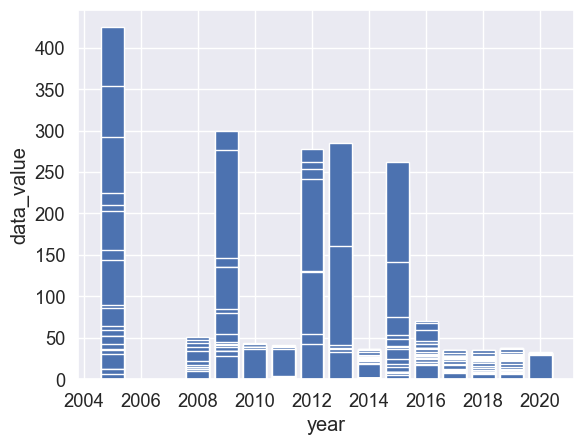

In [34]:
# air_pollution_df.plot(kind='scatter', x='County', y='Rank')
# plt.show()

plt.bar(air_df['year'], air_df['data_value'])
plt.xlabel('year')
plt.ylabel('data_value')
plt.show()

Max pollutants found in perticular year 

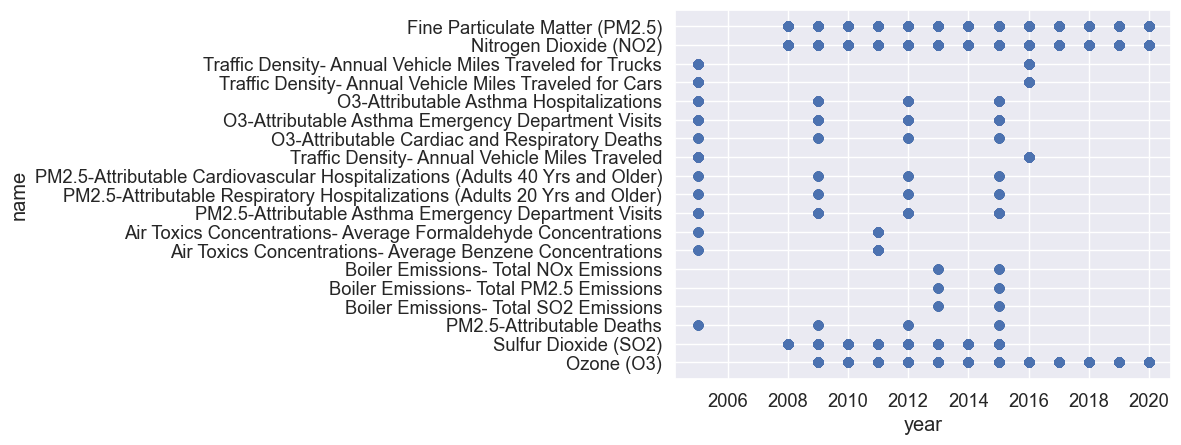

In [35]:
plt.scatter(air_df['year'], air_pollution_df['name'])
plt.xlabel('year')
plt.ylabel('name')
plt.show()

In [36]:
import seaborn as sns

#### Air quality index for top 15 locations in US

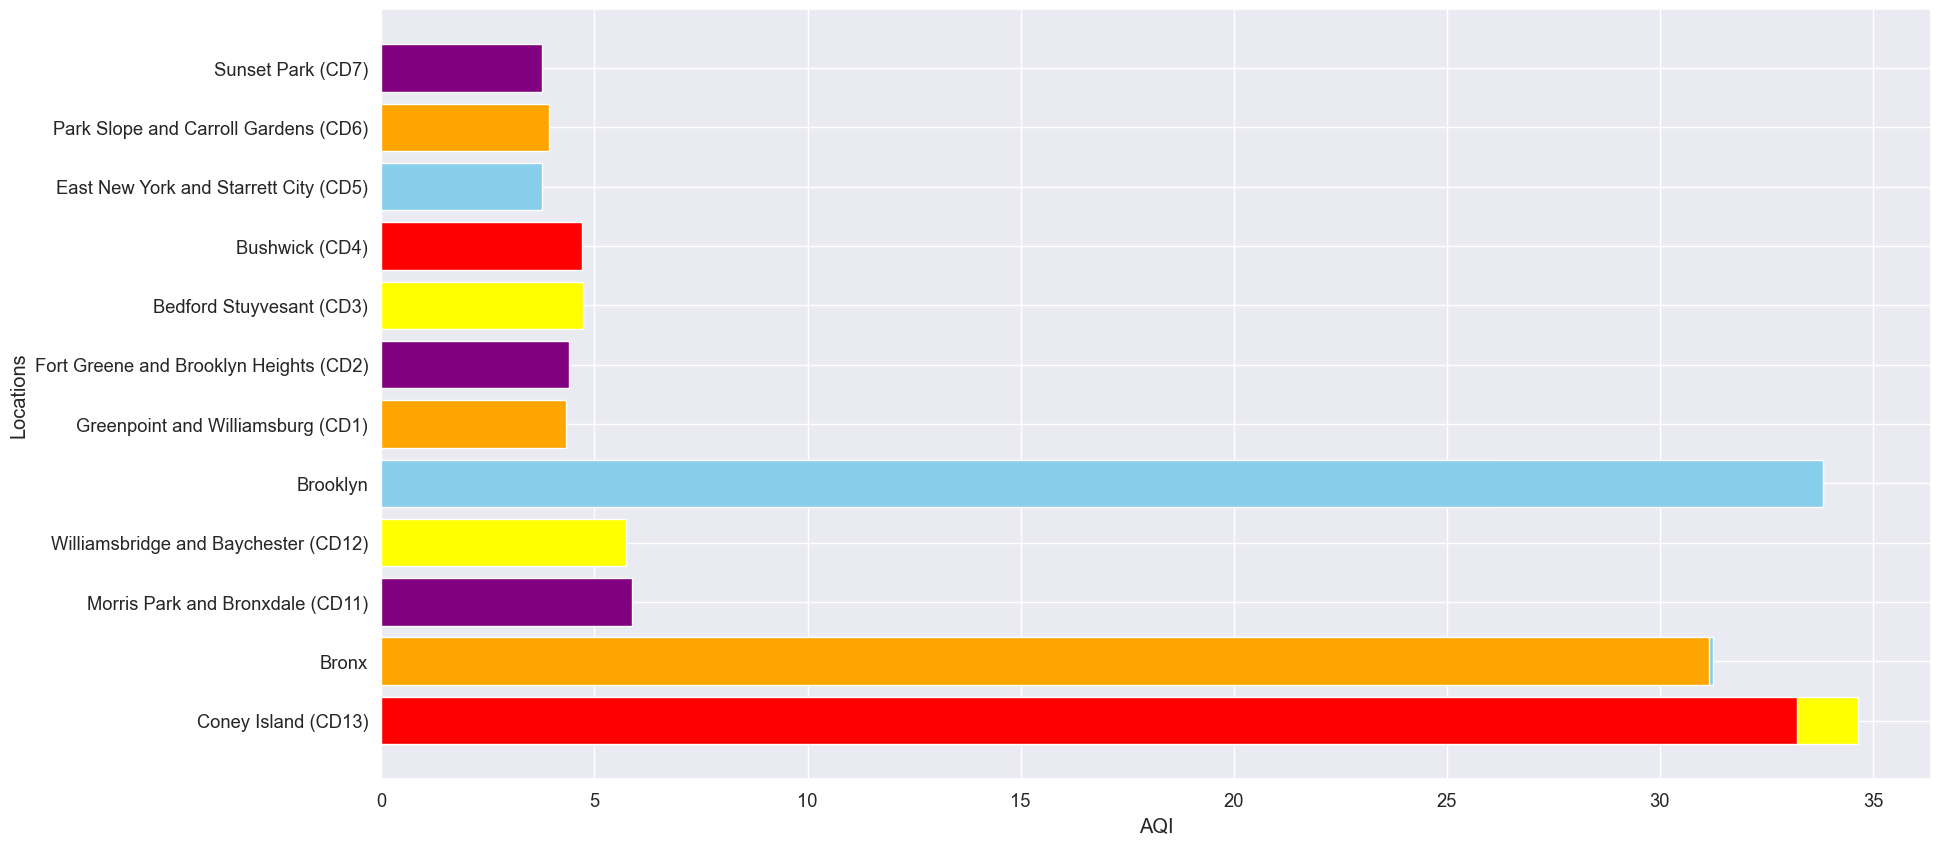

In [37]:
# Create a list of colors
colors = ['yellow', 'red', 'skyblue', 'orange', 'purple' ]

plt.figure(figsize=(20, 10))
# Create a horizontal bar graph with different colors for each bar
for i, (place, value) in enumerate(zip(air_df['geo_place_name'][:15], air_df['data_value'][:15])):
    plt.barh(place, value, color=colors[i%len(colors)])
    
plt.xlabel('AQI')
plt.ylabel('Locations')

plt.show()

Pie graph shows the Max polluted area by ozone pollution 

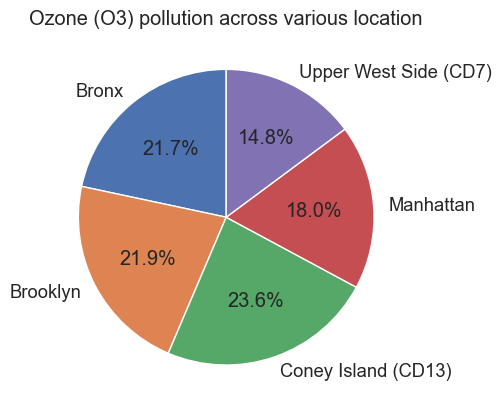

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# load the data
#choosing the first 500 rows from "air_df" dataset for visible visualization
data = air_df[:500]

ozone_data = data[data['name'] == 'Ozone (O3)']

ozone_means = ozone_data.groupby('geo_place_name')['data_value'].mean()

sns.set_style("whitegrid")
sns.set_palette("husl")
sns.set(font_scale=1.2)
plt.pie(ozone_means.values, labels=ozone_means.index, autopct='%1.1f%%', startangle=90)
plt.title("Ozone (O3) pollution across various location")
plt.show()


Pie graph represent pollutent contain in air 

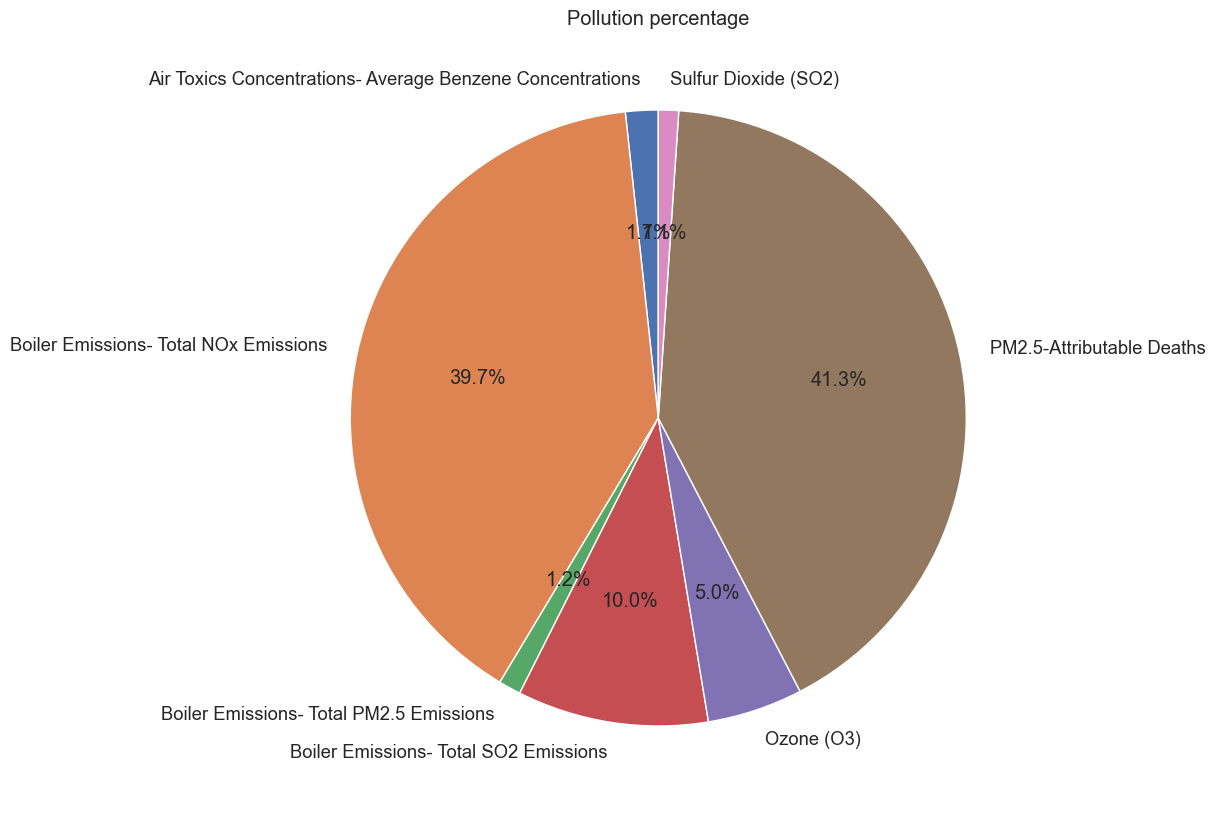

In [39]:
import matplotlib.pyplot as plt
import pandas as pd


data = air_df[:250]
data_grouped = data.groupby('name').sum()

fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(data_grouped['data_value'], labels=data_grouped.index, autopct='%1.1f%%', startangle=90)
ax.set_title('Pollution percentage')
plt.show()


In [40]:
#Volumetric ratio of pollution in air for top 4 locations
air_quality_df = air_df.sort_values(by=['data_value'], ascending = False)
air_quality_df_top_five = air_quality_df[0:4]
air_quality_df_top_five["location"] = ["Central_Harlem", "East_Harlem", "Morrisania","Harlem"]
air_quality_df_top_five.set_index("location")

data = [go.Bar(
        x = air_quality_df_top_five.location,
        y = air_quality_df_top_five.data_value)]
layout = go.Layout(title = 'Volumetric ratio of pollution in air for top 4 locations')

figure = go.Figure(data = data, layout = layout)

figure


C:\Users\rohan\AppData\Local\Temp\ipykernel_29584\282968154.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

